<a href="https://colab.research.google.com/github/CallmeQuant/Studying-Notebook/blob/main/Credit%20Scoring/Fraud_Detection_based_on_Profit_Criterion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")
from google.colab import files

Mounted at /content/drive


In [ ]:
%%capture
!pip install catboost

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score

# Classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [18]:
df_bank = pd.read_csv("drive/My Drive/data/GermanCredit.csv")
df_bank["RESPONSE"] = df_bank["RESPONSE"].map({1: 0, 0: 1})

# Drop OBS# feature:
my_df_binary = df_bank.drop(["OBS#"], axis=1)

# Define input features and target output:
Y = my_df_binary["RESPONSE"]
X = my_df_binary.drop("RESPONSE", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=88)

In [9]:
Y.value_counts()

0    700
1    300
Name: RESPONSE, dtype: int64

In [12]:
ratio = float(Y.value_counts()[0]) / Y.value_counts()[1]

In [19]:
# Initative estimators:
ran = RandomForestClassifier(random_state=88)
log = LogisticRegression()
gbc = GradientBoostingClassifier()
gnb = GaussianNB()
xgb = XGBClassifier(random_state=88,scale_pos_weight=ratio)
lgbm = LGBMClassifier(random_state=88,scale_pos_weight=ratio)
cat = CatBoostClassifier(verbose=False,random_state=0,scale_pos_weight=ratio)

# List of classifiers:
models = [ran, log, gbc, gnb, xgb, lgbm, cat]

In [22]:
%%time
recall_mean = []
recall_sd = []
auc_mean = []
auc_sd = []

# Train all classifiers:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=29)

for mod in models:
    acc = cross_val_score(mod, X_train, y_train, scoring="recall", cv=cv, verbose=False, n_jobs=-1)
    auc = cross_val_score(mod, X_train, y_train, scoring="roc_auc", cv=cv, verbose=False, n_jobs=-1)
    # Recall metric:
    recall_mean.append(acc.mean())
    recall_sd.append(np.std(acc))
    # AUC metric:
    auc_mean.append(auc.mean())
    auc_sd.append(np.std(auc))

# Convert results in form of pandas frame:
df_results = pd.DataFrame({"Model": [mod.__class__.__name__ for mod in models],
                           "Recall_mean": recall_mean,
                           "Recall_sd": recall_sd,
                           "AUC_mean": auc_mean,
                           "AUC_sd": auc_sd})

df_results = df_results.sort_values(by="Recall_mean", ascending=False).reset_index(drop=True)

In [23]:
df_results

,Model,Recall_mean,Recall_sd,AUC_mean,AUC_sd
0,CatBoostClassifier,0.632772,0.050992,0.787708,0.030474
1,GaussianNB,0.596131,0.078183,0.761863,0.042344
2,LGBMClassifier,0.563937,0.055892,0.767863,0.034178
3,XGBClassifier,0.543418,0.051888,0.761044,0.035207
4,LogisticRegression,0.498784,0.074794,0.790781,0.034451
5,GradientBoostingClassifier,0.475043,0.062356,0.777648,0.029904
6,RandomForestClassifier,0.394575,0.071073,0.779581,0.032700


In [34]:
# Train LGBMClassifier, GaussianNB and CatBoostClassifier:
lgbm.fit(X_train, y_train)
cat.fit(X_train, y_train)
xgb.fit(X_train, y_train)


# Probability:
pd_lgbm = lgbm.predict_proba(X_test)[:, 1]
pd_xgb = xgb.predict_proba(X_test)[:, 1]
pd_cat = cat.predict_proba(X_test)[:, 1]

In [35]:
# AUC
print(roc_auc_score(y_test, pd_lgbm))
print(roc_auc_score(y_test, pd_xgb))
print(roc_auc_score(y_test, pd_cat))

0.8149801587301587
0.8012152777777778
0.8229166666666666


In [60]:
# Function calculates profit with given cutoff when interest rate of 4.5%:

def profit_by_cutoff(cutoff, pred_prob):
    rate = 0.045
    pred_bg = (pred_prob >= cutoff).astype(int)
    gg = X_test[(y_test == 0) & (pred_bg == 0)]
    bg = X_test[(y_test == 1) & (pred_bg == 0)]
    profit = np.sum(rate * gg["AMOUNT"]) - np.sum(bg["AMOUNT"])
    return profit


def profit(cutoff):
    pro_lgbm = profit_by_cutoff(cutoff=cutoff, pred_prob=pd_lgbm)
    pro_xgb = profit_by_cutoff(cutoff=cutoff, pred_prob=pd_xgb)
    pro_cat = profit_by_cutoff(cutoff=cutoff, pred_prob=pd_cat)
    df_pro = pd.DataFrame({"Profit_LGBM": [pro_lgbm],
                           "Profit_XGB": [pro_xgb],
                           "Profit_CAT": [pro_cat],
                           "Cutoff": [cutoff]})

    return df_pro


# If cutoff = 0.02:
print(profit(cutoff=0.02))

# Profit for the two models by a range of cutoff:
df_profit = pd.DataFrame()

for j in np.arange(0.01, 0.3, 0.005):
    df_j = profit(j)
    df_profit = df_profit.append(df_j)

df_profit = df_profit.reset_index(drop = True)

   Profit_LGBM  Profit_XGB  Profit_CAT  Cutoff
0      -2248.5   -14462.01      242.55    0.02


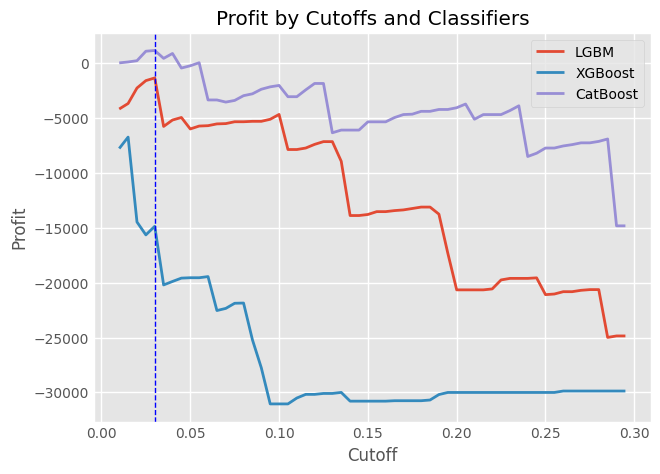

In [73]:
plt.plot("Cutoff", "Profit_LGBM", data=df_profit, label="LGBM", lw=2)
plt.plot("Cutoff", "Profit_XGB", data=df_profit, label="XGBoost", lw=2)
plt.plot("Cutoff", "Profit_CAT", data=df_profit, label="CatBoost", lw=2)
plt.axvline(x = df_profit['Cutoff'][cutoff_id], color = 'b', linestyle='--', linewidth = 1)
plt.title("Profit by Cutoffs and Classifiers")
plt.xlabel("Cutoff")
plt.ylabel("Profit")
plt.legend()
plt.show()